In [13]:
import pandas as pd
import torch
from torch_geometric.data import Data

# Charger les données
data = pd.read_excel("hotel_reviews_with_score_final.xlsx")

# Créer des IDs pour utilisateurs et hôtels
user_ids = data["user type"].astype("category").cat.codes
hotel_ids = data["Hotel name"].astype("category").cat.codes

num_users = user_ids.nunique()
num_hotels = hotel_ids.nunique()

print("Nombre d'utilisateurs:", num_users)
print("Nombre d'hôtels:", num_hotels)

# Source = utilisateurs
edge_src = torch.tensor(user_ids.values, dtype=torch.long)

# Destination = hôtels (offset)
edge_dst = torch.tensor(hotel_ids.values + num_users, dtype=torch.long)

# Edge index (format PyG)
edge_index = torch.stack([edge_src, edge_dst], dim=0)

# Poids des arêtes = Score Final
edge_weight = torch.tensor(data["Score_Final"].values, dtype=torch.float)

# Créer les features des nœuds
num_nodes = num_users + num_hotels
x = torch.ones((num_nodes, 1))

# Créer l'objet Data du graphe
graph_data = Data(
    x=x,
    edge_index=edge_index,
    edge_weight=edge_weight
)

print("Graphe créé:")
print(graph_data)

Nombre d'utilisateurs: 6
Nombre d'hôtels: 1173
Graphe créé:
Data(x=[1179, 1], edge_index=[2, 105698], edge_weight=[105698])


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import mean_squared_error
import numpy as np


In [15]:
# Cible = poids des arêtes
y = graph_data.edge_weight

# Nombre d’arêtes
num_edges = y.size(0)

# Split train / test
perm = torch.randperm(num_edges)
train_size = int(0.8 * num_edges)

train_idx = perm[:train_size]
test_idx  = perm[train_size:]

y_train = y[train_idx]
y_test  = y[test_idx]

print("Train edges:", len(train_idx))
print("Test edges:", len(test_idx))


Train edges: 84558
Test edges: 21140


In [16]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x.squeeze()


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = GCN().to(device)
graph_data = graph_data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()


In [18]:
epochs = 20  # Moins d'epochs
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    node_embeddings = model(graph_data.x, graph_data.edge_index)

    # prédiction sur les arêtes d'entraînement seulement
    preds = node_embeddings[graph_data.edge_index[1]][train_idx]

    loss = loss_fn(preds, y_train)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if epoch % 5 == 0:
        print(f"Epoch {epoch}/{epochs} | Loss = {loss.item():.4f}")

print("✅ Entraînement terminé")

Epoch 0/20 | Loss = 14.7996
Epoch 5/20 | Loss = 9.2696
Epoch 10/20 | Loss = 6.9779
Epoch 15/20 | Loss = 7.7507
✅ Entraînement terminé


In [19]:
model.eval()
with torch.no_grad():
    node_embeddings = model(graph_data.x, graph_data.edge_index)
    preds_test = node_embeddings[graph_data.edge_index[1]][test_idx]

rmse = np.sqrt(mean_squared_error(y_test.cpu(), preds_test.cpu()))
print("RMSE sur test:", rmse)


RMSE sur test: 2.6488353689207464


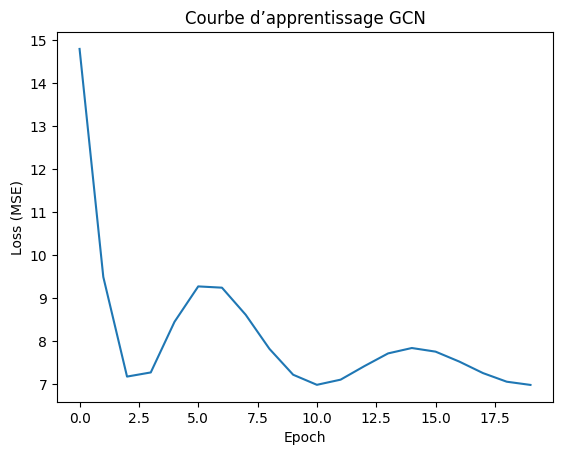

In [20]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Courbe d’apprentissage GCN")
plt.show()


In [21]:
torch.save(model.state_dict(), "gcn_recommender.pth")
print("✅ Modèle GCN sauvegardé")


✅ Modèle GCN sauvegardé


In [22]:

# Sauvegarder le modèle et les données pour l'évaluation
import pickle

torch.save(model, 'gcn_recommender.pth')

with open('evaluation_data.pkl', 'wb') as f:
    pickle.dump({
        'graph_data': graph_data,
        'test_idx': test_idx,
        'y_test': y_test
    }, f)

print("Modèle et données sauvegardés !")

Modèle et données sauvegardés !
